In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, MultipleLocator
from scipy.fft import fft, fftshift, fftfreq, ifft, ifftshift
from tftb.processing.cohen import WignerVilleDistribution as WVD

sys.path.append('../pyVisOS/')
#sys.path.append('../')
import osh5def
import osh5io
import osh5vis
import osh5utils

import Triangle

In [7]:
def getIntersectPoints(m1:np.ndarray,p1:np.ndarray,m2:float,p2:tuple) -> tuple:
    """m1: array containing slopes of incoming lines
    p1 = array containing (x1,y1), points along incoming lines
    m2: slope of line 2
    p2 = (x2,y2): a point along line 2
    returns -> array containing intersection points"""

    b1 = p1[:,1] - m1*p1[:,0]
    b2 = p2[1] - m2*p2[0]

    x_i = (b1-b2)/(m2-m1)
    y_i = m1*x_i + b1

    points = np.array(p1)
    points[:,0] = x_i
    points[:, 1] = y_i

    return points

def angleBetweenTwoSlopes(m1, m2):
    """Returns angle between two lines with slopes m1 and m2, in radians"""
    return np.arctan2((m2-m1),(1+m1*m2)) # perhaps need just arctan

def distance(p1:np.ndarray, p2:np.ndarray) -> np.ndarray:
    """Returns distance between (x1,y1) and (x2,y2)"""
    return np.sqrt((p2[:,0]-p1[:,0])**2 + (p2[:,1]-p1[:,1])**2)

def n_(omega, N:float):
    """For a given laser frequency omega [measured in omega_p]
    and relative plasma density N, returns refractive index
    in that plasma

    sqrt(1-N*omega^-2)"""
    return np.sqrt(1-N/(np.square(omega)))

def n_osiris(om, N):
    n_str = str(N).replace('.', '-')
    temp = np.genfromtxt('refractive/n/'+n_str+'.csv',
                             delimiter=',', skip_header=1, names=['omega', 'omega_rel', 'ReN', 'ImN'])

    n_out = np.zeros_like(om)
    delta_omega = temp['omega_rel'][2] - temp['omega_rel'][1]
    for i in range(len(om)):
        a = om[i]
        p1 = a - delta_omega
        p2 = a + delta_omega

        a1 = int(np.argwhere(temp['omega_rel'] > p1)[0])
        a2 = int(np.argwhere(temp['omega_rel'] < p2)[-1])

        #print(a, 'lies between', temp['omega'][a1], 'and', temp['omega'][a2])

        d1 = a - temp['omega_rel'][a1]
        d2 = temp['omega_rel'][a2] - a

        n_out[i] = d2/(d1+d2)*temp['ReN'][a1]+d1/(d1+d2)*temp['ReN'][a2]
    return n_out

def boundary(in_slope:np.ndarray, boundary_slope:float, enter:bool, omega:np.ndarray, N:float):
    """Returns out slope
    enter: True = going from vacuum to plasma
            False = going from plasma to vacuum"""

    normal_slope = -1/boundary_slope
    theta1 = np.abs(angleBetweenTwoSlopes(in_slope, normal_slope))
    if enter:
        theta2 = np.arcsin(n_(omega, 0)/n_(omega, N)*np.sin(theta1))
    else:
        theta2 = np.arcsin(n_(omega, N)/n_(omega, 0)*np.sin(theta1))

    greater_case = np.tan(theta2 + np.arctan2(normal_slope,1)) # if in_slope > normal_slope
    smaller_case = np.tan(np.arctan2(normal_slope,1) - theta2) # if in_slope < normal_slope
    
    out_slope = np.where(in_slope > normal_slope, greater_case, smaller_case)
    out_slope = np.where(in_slope == normal_slope, in_slope, out_slope)

    return out_slope

def boundary_osiris(in_slope:np.ndarray, boundary_slope:float, enter:bool, omega:np.ndarray, N:float):
    """Returns out slope
    enter: True = going from vacuum to plasma
            False = going from plasma to vacuum"""

    normal_slope = -1/boundary_slope
    theta1 = np.abs(angleBetweenTwoSlopes(in_slope, normal_slope))
    if enter:
        theta2 = np.arcsin(1/n_osiris(omega, N)*np.sin(theta1))
    else:
        theta2 = np.arcsin(n_osiris(omega, N)/1*np.sin(theta1))

    greater_case = np.tan(theta2 + np.arctan2(normal_slope,1)) # if in_slope > normal_slope
    smaller_case = np.tan(np.arctan2(normal_slope,1) - theta2) # if in_slope < normal_slope
    
    out_slope = np.where(in_slope > normal_slope, greater_case, smaller_case)
    out_slope = np.where(in_slope == normal_slope, in_slope, out_slope)

    return out_slope

def drawSegment(ax, p1, p2, **kwargpassthrough):
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], **kwargpassthrough)

def raytrace(N, omega:np.ndarray, left_sides, right_sides, tips):
    intersections = np.ndarray(shape=(len(left_sides)+len(right_sides)+2, len(omega), 2))
    lengths = np.ndarray(shape=(len(left_sides)+len(right_sides)+1, len(omega)))

    m = np.zeros_like(omega) # all frequencies start fully horizontal
    points = np.full((len(omega),2), (0.,0.))

    num = 0
    intersections[num] = points # first row is starting points for all omega
    # for now this they are all (0,0), but if i wanted to start with some frequencies delayed (chirp)
    # this is where that could be set
    num += 1

    for i in range(len(tips)):
        intersections[num] = getIntersectPoints(m, intersections[num-1], left_sides[i], tips[i])
        m = boundary(m, left_sides[i], True, omega, N)
        lengths[num-1] = distance(intersections[num-1], intersections[num])
        num += 1

        intersections[num] = getIntersectPoints(m, intersections[num-1], right_sides[i], tips[i])
        m = boundary(m, right_sides[i], False, omega, N)
        lengths[num-1] = distance(intersections[num-1], intersections[num])
        num += 1

    intersections[num] = getIntersectPoints(m, intersections[num-1], 1, intersections[num-1, 0] + [1000,0])
    lengths[num-1] = distance(intersections[num-1], intersections[num])
    
    return intersections, lengths

def raytrace_osiris(N, omega:np.ndarray, left_sides, right_sides, tips):
    intersections = np.ndarray(shape=(len(left_sides)+len(right_sides)+2, len(omega), 2))
    lengths = np.ndarray(shape=(len(left_sides)+len(right_sides)+1, len(omega)))

    m = np.zeros_like(omega) # all frequencies start fully horizontal
    points = np.full((len(omega),2), (0.,0.))

    num = 0
    intersections[num] = points # first row is starting points for all omega
    # for now this they are all (0,0), but if i wanted to start with some frequencies delayed (chirp)
    # this is where that could be set
    num += 1

    for i in range(len(tips)):
        intersections[num] = getIntersectPoints(m, intersections[num-1], left_sides[i], tips[i])
        m = boundary_osiris(m, left_sides[i], True, omega, N)
        lengths[num-1] = distance(intersections[num-1], intersections[num])
        num += 1

        intersections[num] = getIntersectPoints(m, intersections[num-1], right_sides[i], tips[i])
        m = boundary_osiris(m, right_sides[i], False, omega, N)
        lengths[num-1] = distance(intersections[num-1], intersections[num])
        num += 1

    intersections[num] = getIntersectPoints(m, intersections[num-1], 1, intersections[num-1, 0] + [1000,0])
    lengths[num-1] = distance(intersections[num-1], intersections[num])
    
    return intersections, lengths

def plotPrisms(ax, N, tip1, tip2, mirror, theta):
    theta = np.deg2rad(theta)    # convert to radians
    tips = [tip1, tip2]
    alpha = np.pi/2. + theta - np.arcsin(n_(1, N)*np.sin(theta))

    tips.append((2*mirror - tips[1][0], tips[1][1]))
    tips.append((2*mirror - tips[0][0], tips[0][1]))
    left_sides = [np.tan(alpha - theta), np.tan(alpha + theta), np.tan(-alpha + theta), np.tan(-alpha - theta)]
    right_sides = [np.tan(alpha + theta), np.tan(alpha - theta), np.tan(-alpha - theta), np.tan(-alpha + theta)]
    mid_slopes = [np.tan(alpha), np.tan(alpha), np.tan(-alpha), np.tan(-alpha)]
    for i in range(len(tips)):
        X = np.linspace(0, tips[i][0], 2)
        ax.plot(X, left_sides[i]*(X-tips[i][0])+tips[i][1], c='black', linestyle='--')
        X = np.linspace(0, mirror*2, 2)
        ax.plot(X, mid_slopes[i]*(X-tips[i][0])+tips[i][1], c='blue', linestyle=':', alpha=0.5)
        X = np.linspace(tips[i][0], mirror*2, 2)
        ax.plot(X, right_sides[i]*(X-tips[i][0])+tips[i][1], c='black', linestyle='--')

        
    return left_sides, right_sides, tips

def phaseAccumulation(N, om, lengths):
    # lengths[segments, omega]
    psi = np.zeros_like(om)
    vacuumLength = np.sum(lengths[::2], axis=0)
    plasmaLength = np.sum(lengths[1::2], axis=0)
    psi = -om*(n_(om, 0)*vacuumLength + n_(om,N)*plasmaLength)
    return psi

def OPL(N, om, lengths):
    opl = np.zeros_like(om) # [segments, omega]
    vacuumLength = np.sum(lengths[::2], axis=0)
    plasmaLength = np.sum(lengths[1::2], axis=0)
    opl = n_(om, 0) * vacuumLength + n_(om, N) * plasmaLength
    return opl
    
def phaseAccumulation_osiris(N, om, lengths):
    # lengths[segments, omega]
    psi = np.zeros_like(om)
    vacuumLength = np.sum(lengths[::2], axis=0)
    plasmaLength = np.sum(lengths[1::2], axis=0)
    psi = om*(1*vacuumLength + n_osiris(om,N)*plasmaLength)
    return psi

def OPL_osiris(N, om, lengths):
    opl = np.zeros_like(om) # [segments, omega]
    vacuumLength = np.sum(lengths[::2], axis=0)
    plasmaLength = np.sum(lengths[1::2], axis=0)
    opl = 1 * vacuumLength + n_osiris(om, N) * plasmaLength
    return opl

In [167]:
c = 299792458*1e6*1e-15 # um / fs
om_0 = 2*np.pi*c/0.8 # 1/fs

N = 0.2
n = lambda om : np.sqrt(1 - N*om_0**2/om**2) # refractive index

brew = np.arctan2(n(om_0), 1)
brew_ = np.arctan2(1, n(om_0))
theta = np.arcsin(np.sin(brew) / n(om_0)) * 180/np.pi

tip1 = (40000,8000)
tip2 = (270000,38000)
mirror = tip2[0]*1.5
#theta = 30

g = np.arctan2(tip2[1] - tip1[1], tip2[0] - tip1[0]) - brew_ + brew
L = np.abs(np.cos(g))*np.sqrt((tip2[1] - tip1[1])**2 + (tip2[0] - tip1[0])**2) * c/om_0
M = (mirror - tip2[0])* c/om_0
a = np.cos(brew_ - g)
b = np.sin(brew_ - g)

print('brew = %.2f° \tbrew_ = %.2f° \tgamma = %.2f°' % (np.rad2deg(brew), np.rad2deg(brew_), np.rad2deg(g)))
print('L = %.2f[um]\tM = %.2f[cm]' % (L, M/10000))

brew = 41.81° 	brew_ = 48.19° 	gamma = 1.05°
L = 29527.59[um]	M = 1.72[cm]


In [168]:
from numpy import cos, sin, tan, arcsin, arctan2, sqrt

sec = lambda x : 1. / cos(x)
sec2 = lambda x : 1. / cos(x)**2
sec3 = lambda x : 1. / cos(x)**3
sec4 = lambda x : 1. / cos(x)**4


n = lambda om, N=N : sqrt(1 - N*om_0**2/om**2)
d_n = lambda om, N=N : (N*om_0**2/om**2)/sqrt(om**2 - N*om_0**2)
d2_n = lambda om, N=N: N*om_0**2/om**3 * (2*N*om_0**2 - 3*om**2)/((om**2 - N*om_0**2)**(3/2))
d3_n = lambda om, N=N : 3*N*om_0**2/om**4 * (2*(N*om_0**2)**2 - 5*N*om_0**2*om**2+4*om**4)/((om**2 - N*om_0**2)**(5/2))

phi1_ = lambda n : arcsin(sin(brew) / n)
phi2_ = lambda n : 2*brew_ - phi1_(n)
phi2 =  lambda n : arcsin(sin(2*brew_) * sqrt(n**2 - sin(brew)**2) - cos(2*brew_)*sin(brew))

d_phi2 = lambda n : sec(phi2(n)) * (sin(phi2_(n)) + cos(phi2_(n))*tan(phi1_(n)))
d2_phi2 = lambda n : tan(phi2(n)) * d_phi2(n)**2 - tan(phi1_(n))**2 / n * d_phi2(n)
d3_phi2 = lambda n : sec2(phi2(n)) * d_phi2(n)**3 + 2*tan(phi2(n))*d_phi2(n)*d2_phi2(n) + (tan(phi1_(n))**2*(2*sec2(phi1_(n))+1)) * d_phi2(n)/n**2 - tan(phi1_(n))**2 * d2_phi2(n) / n


d_phi1_ = lambda n : -1*tan(phi1_(n))/n
d2_phi1_ = lambda n : tan(phi1_(n))*(1+sec2(phi1_(n)))/n**2
d3_phi1_ = lambda n : -1*tan(phi1_(n))*(3*sec4(phi1_(n)) + sec2(phi1_(n)) + 2)/n**3


a1 = lambda n, L=L, g=g: L*a/cos(g) * sec(phi2(n))

d_a1 = lambda n, L=L, g=g : L*a/cos(g) * sec(phi2(n))*tan(phi2(n))*d_phi2(n)

d2_a1 = lambda n, L=L, g=g : L*a/cos(g) * ((2*sec3(phi2(n)) - sec(phi2(n)))*d_phi2(n)**2 +
                      sec(phi2(n))*tan(phi2(n))*d2_phi2(n))

d3_a1 = lambda n, L=L, g=g :L*a/cos(g) * (tan(phi2(n))*sec(phi2(n))*(6*sec2(phi2(n))-1) * d_phi2(n)**3 +
                                (2*sec3(phi2(n))-sec(phi2(n)))*3*d_phi2(n)*d2_phi2(n) + 
                                tan(phi2(n))*sec(phi2(n))*d3_phi2(n))


a2 = lambda n, L=L, g=g : L/cos(g)*sin(2*brew_) * (b - a*tan(phi2(n))) * sec(phi1_(n))

d_a2 = lambda n, L=L, g=g : L/cos(g)*sin(2*brew_) * (-a*sec2(phi2(n))*d_phi2(n)*sec(phi1_(n)) +
                                 (b - a*tan(phi2(n)))*sec(phi1_(n))*tan(phi1_(n))*d_phi1_(n))

d2_a2 = lambda n, L=L, g=g : L/cos(g)*sin(2*brew_) * (-a*(2*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)**2 + sec2(phi2(n))*d2_phi2(n))*sec(phi1_(n)) +
                                 2*-a*sec2(phi2(n))*d_phi2(n)*sec(phi1_(n))*tan(phi1_(n)) * d_phi1_(n) + 
                                 (b-a*tan(phi2(n)))*(2*sec3(phi1_(n))-sec(phi1_(n)))*d_phi1_(n)**2 +
                                 (b-a*tan(phi2(n)))*sec(phi1_(n))*tan(phi1_(n))*d2_phi1_(n))

d3_a2 = lambda n, L=L, g=g : L/cos(g)*sin(2*brew_) * (-a*(2*sec2(phi2(n))*(3*sec2(phi2(n))-2)*d_phi2(n)**3 + 6*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)*d2_phi2(n) + sec2(phi2(n))*d3_phi2(n))*sec(phi1_(n)) +
                                            -3*a * (2*tan(phi2(n)) * sec2(phi2(n)) * d_phi2(n)**2 + sec2(phi2(n)) * d2_phi2(n)) * sec(phi1_(n)) * tan(phi1_(n)) * d_phi1_(n) + 
                                            -3*a * sec2(phi2(n)) * d_phi2(n) * (2*sec3(phi1_(n))-sec(phi1_(n))) * d_phi1_(n)**2 +
                                            -3*a * sec2(phi2(n)) * d_phi2(n) * sec(phi1_(n)) * tan(phi1_(n)) * d2_phi1_(n) +
                                            (b-a*tan(phi2(n))) * sec(phi1_(n)) * tan(phi1_(n)) * (6*sec2(phi1_(n))-1) * d_phi1_(n)**3 +
                                            3*(b-a*tan(phi2(n))) * (2*sec3(phi1_(n))-sec(phi1_(n))) * d_phi1_(n) * d2_phi1_(n) +
                                            (b-a*tan(phi2(n))) * sec(phi1_(n)) * tan(phi1_(n)) * d3_phi1_(n))


a3 = lambda n, L=L, g=g : M - sin(brew)*L/cos(g) * (b-a*tan(phi2(n))) * (cos(2*brew_) + sin(2*brew_)*tan(phi1_(n)))

d_a3 = lambda n, L=L, g=g : -L*sin(brew)/cos(g) * (-a*sec2(phi2(n))*d_phi2(n)*(cos(2*brew_) + sin(2*brew_)*tan(phi1_(n))) +
                              (b-a*tan(phi2(n)))*sin(2*brew_)*sec2(phi1_(n))*d_phi1_(n))

d2_a3 = lambda n, L=L, g=g : -L*sin(brew)/cos(g) * (-a*(2*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)**2 + sec2(phi2(n))*d2_phi2(n))*(cos(2*brew_)+sin(2*brew_)*tan(phi1_(n))) +
                               2*-a*sec2(phi2(n))*d_phi2(n) * sin(2*brew_)*sec2(phi1_(n))*d_phi1_(n) +
                               (b-a*tan(phi2(n)))*sin(2*brew_)*(2*tan(phi1_(n))*sec2(phi1_(n))*d_phi1_(n)**2 + sec2(phi1_(n))*d2_phi1_(n)))

d3_a3 = lambda n, L=L, g=g : -L*sin(brew)/cos(g)*sin(2*brew_) * (-a*(2*sec2(phi2(n))*(3*sec2(phi2(n))-2)*d_phi2(n)**3 + 6*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)*d2_phi2(n) + sec2(phi2(n))*d3_phi2(n))*(1./tan(2*brew_) + tan(phi1_(n))) +
                                                       -3*a * sec2(phi1_(n)) * d_phi1_(n) * (2*tan(phi2(n))*sec2(phi2(n))*d_phi2(n)**2 + sec2(phi2(n))*d2_phi2(n)) +
                                                       -3*a * sec2(phi2(n)) * d_phi2(n) * (2*tan(phi1_(n))*sec2(phi1_(n))*d_phi1_(n)**2 + sec2(phi1_(n))*d2_phi1_(n)) +
                                                       (b-a*tan(phi2(n)))*(2*sec2(phi1_(n))*(3*sec2(phi1_(n))-2)*d_phi1_(n)**3 + 6*tan(phi1_(n))*sec2(phi1_(n))*d_phi1_(n)*d2_phi1_(n) + sec2(phi1_(n))*d3_phi1_(n)))



P = lambda om, L=L, g=g : 2*(a1(n(om), L, g) + n(om)*a2(n(om), L, g) + a3(n(om), L, g))
d_P = lambda om, L=L, g=g : 2*((d_a1(n(om), L, g) + a2(n(om), L, g) + n(om)*d_a2(n(om), L, g) + d_a3(n(om), L, g)) * d_n(om) )# dP/dw not dP/dn
d2_P = lambda om, L=L, g=g : 2*((d2_a1(n(om), L, g) + 2*d_a2(n(om), L, g) + n(om)*d2_a2(n(om), L, g) + d2_a3(n(om), L, g)) * d_n(om)**2 + (d_a1(n(om), L, g) + a2(n(om), L, g) + n(om)*d_a2(n(om), L, g) + d_a3(n(om), L, g)) * d2_n(om))
d3_P = lambda om, L=L, g=g : 2*((d3_a1(n(om), L, g) + 3*d2_a2(n(om), L, g) + n(om)*d3_a2(n(om), L, g) + d3_a3(n(om), L, g))*d_n(om)**3 + 3*(d2_a1(n(om), L, g) + 2*d_a2(n(om), L, g) + n(om)*d2_a2(n(om), L, g) + d2_a3(n(om), L, g))*d_n(om)*d2_n(om) + (d_a1(n(om), L, g) + a2(n(om), L, g) + n(om)*d_a2(n(om), L, g) + d_a3(n(om), L, g))*d3_n(om))


psi = lambda om, L=L, g=g : -1/c*om*P(om, L, g)
d_psi = lambda om, L=L, g=g : -1/c * (P(om, L, g) + om*d_P(om, L, g))
d2_psi = lambda om, L=L, g=g : -1/c * (2*d_P(om, L, g) + om*d2_P(om, L, g))
d3_psi = lambda om, L=L, g=g : -1/c * (3*d2_P(om, L, g) + om*d3_P(om, L, g))

psi_taylor = lambda om_0, om, L=L, g=g : psi(om_0, L, g) + d_psi(om_0, L, g)*(om-om_0) + (1./2.)*d2_psi(om_0, L, g)*(om-om_0)**2 + (1./6.)*d3_psi(om_0, L, g)*(om-om_0)**3
psi_taylor2 = lambda om_0, om, L=L, g=g : (1./2.)*d2_psi(om_0, L, g)*(om-om_0)**2 + (1./6.)*d3_psi(om_0, L, g)*(om-om_0)**3


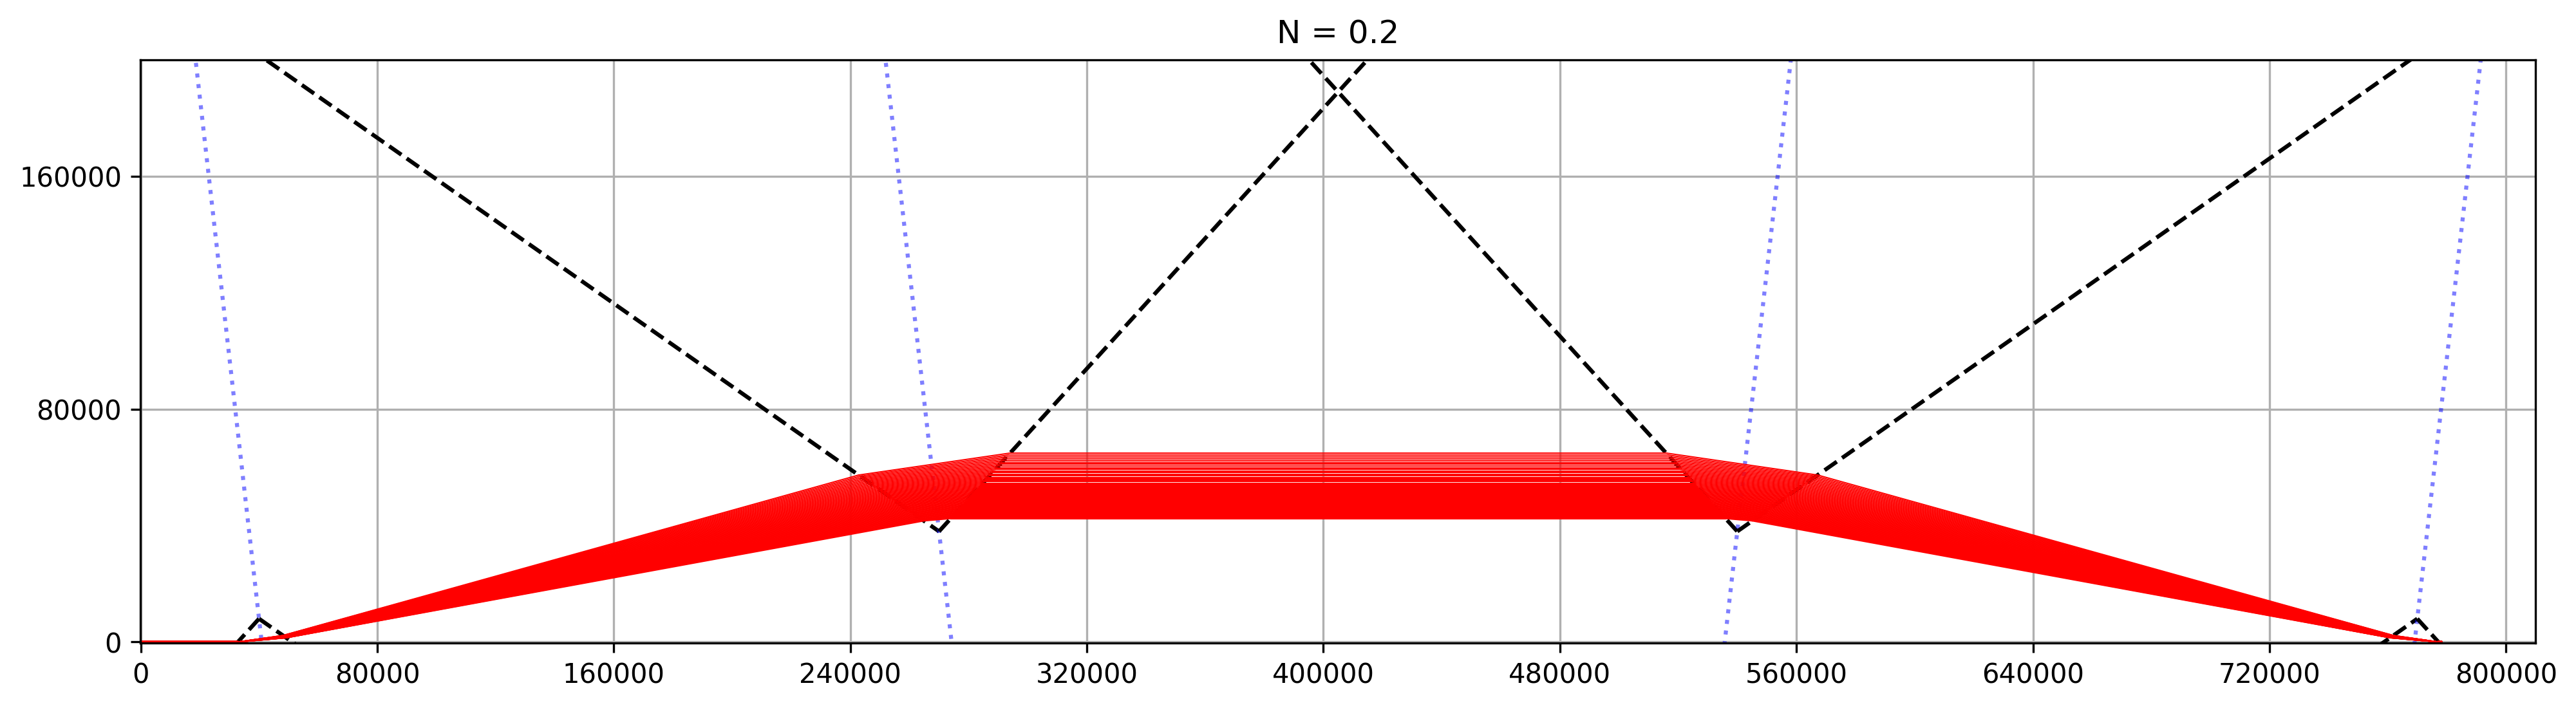

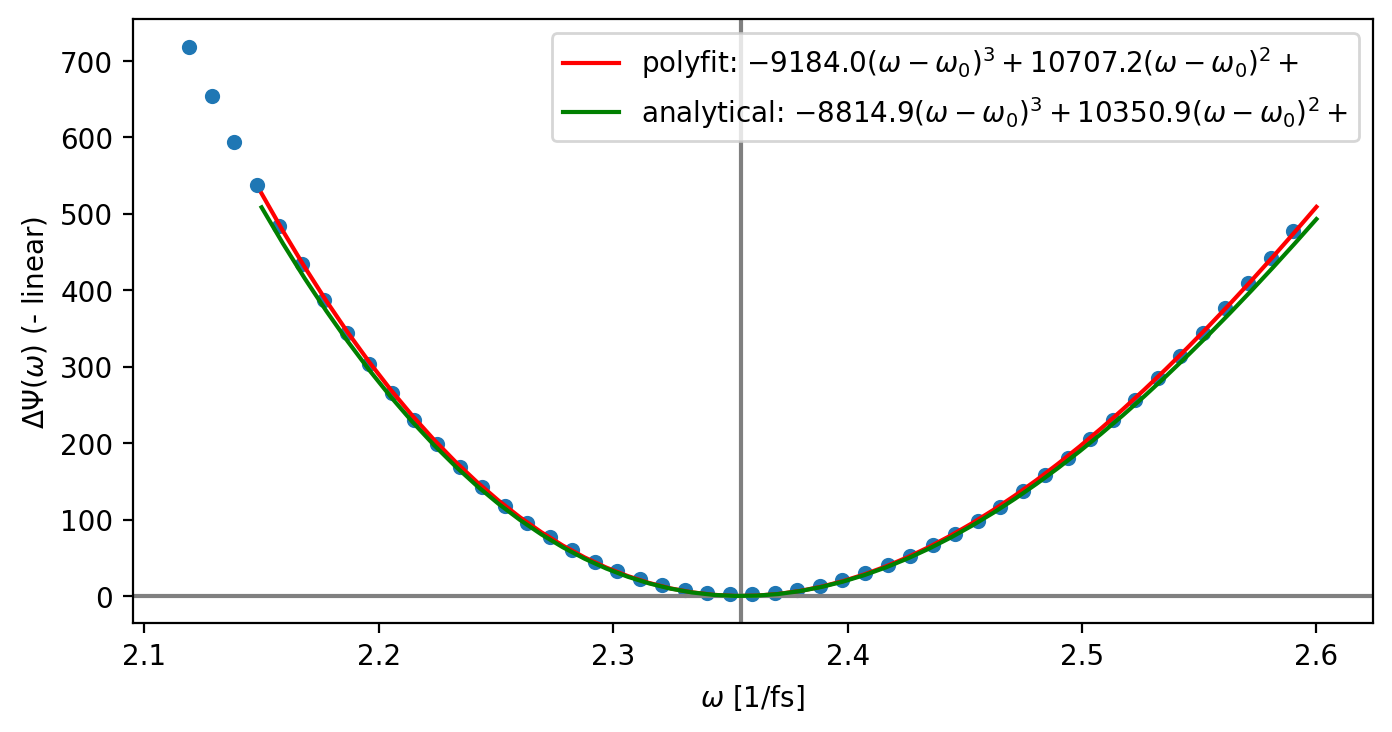

In [169]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,4))

#0.4, 30, (400,300), (1700, 0), 2100, 800))
left_sides, right_sides, tips = plotPrisms(ax, N, tip1, tip2, mirror, theta)

#om = w_2[::2] / om_0
om = np.array([ 0.9, 0.92, 0.94, 0.96, 0.98, 1., 1.02, 1.04, 1.06, 1.08, 1.1])
om = np.linspace(0.9, 1.1)
ax.set(ylim=[-300,200000], xlim=[-100,mirror*2], title='N = %.1f' % N)
if True:
    ax.grid()
    ax.xaxis.set_major_locator(MultipleLocator(80000))
    ax.yaxis.set_major_locator(MultipleLocator(80000))

    #om = np.array([0.9, 1., 1.1])
    #om = np.array([ 0.9, 0.92, 0.94, 0.96, 0.98, 1., 1.02, 1.04, 1.06, 1.08, 1.1])
    #colors=['red', 'green', 'blue']
    #colors = [ 'darkred', 'red', 'orangered', 'orange', 'yellow', 'greenyellow', 'green', 'lightseagreen', 'deepskyblue', 'blue', 'aquamarine']


    intersections, lengths = raytrace(N, om, left_sides, right_sides, tips)
    #intersections_osiris, lengths_osiris = raytrace_osiris(N, om, left_sides, right_sides, tips)

    phase = phaseAccumulation(N, om, lengths)
    phase -= phase[np.argwhere(om >= 1.)[0]]

    #psi_osiris = phaseAccumulation_osiris(N, om, lengths_osiris)
    #psi_osiris -= psi_osiris[np.argwhere(om >= 1.)[0]]

    opl = OPL(N, om, lengths)
    opl -= opl[np.argwhere(om >= 1.)[0]]
    opl *= 0.8 / 2 / np.pi

    for freq in range(len(om)):
        for boundaryline in range(1, len(intersections)):
            drawSegment(ax, intersections[boundaryline-1, freq], intersections[boundaryline, freq], c='r', linewidth=0.5)

            #drawSegment(ax, intersections_osiris[boundaryline-1, freq], intersections_osiris[boundaryline, freq], alpha=1., linestyle='--', c='b')


    # plot optical path difference
    fig, ax = plt.subplots(1, 1, dpi=200, figsize=(8,4))
    """ax[0].scatter(om*om_0, opl)
    ax[0].set(xlim=[2,3], xlabel=r'$\omega$ [$\omega_0$]', ylabel=r'optical path difference [$\mu m$]', title='N = '+str(N))

    coeff = np.polyfit(om*om_0, opl, 3)
    x = np.linspace(0.9*om_0, 1.1*om_0)
    y = np.zeros_like(x)
    s = ''
    for i in range(len(coeff)):
        y += coeff[i]*x**(len(coeff)-1-i)
        if len(coeff)-1-i != 0:
            s += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
        else:
            s += r'$%.1f$' % coeff[i]
    ax[0].plot(x, y, label=s, c='r')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))
    ax[0].legend() """

    om_2 = om*om_0
    
    # plot with n
    if True:
        coeff = np.polyfit(om_2-om_0, phase, 3)
        coeff_analytical = [d3_psi(om_0)/6, d2_psi(om_0)/2, d_psi(om_0), psi(om_0)]
        x = np.linspace(2.15, 2.6)
        y = np.zeros_like(x)
        s = ''
        for i in range(len(coeff)):
            y += coeff[i]*(x-om_0)**(len(coeff)-1-i)
            if len(coeff)-1-i != 0:
                s += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
            else:
                s += r'$%.1f$' % coeff[i]
        #ax[0].plot(x, y, label=s, c='r')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))
        #ax[0].legend()

        psi_shifted = phase - coeff[-2]*(om_2-om_0) - coeff[-1]
        z = np.zeros_like(x)
        s1 = 'polyfit: '
        s2 = 'analytical: '
        for i in range(len(coeff)-2):
            z += coeff[i]*(x-om_0)**(len(coeff)-1-i)
            s1 += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
            s2 += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff_analytical[i], len(coeff_analytical)-1-i)
        ax.plot(x, z, label=s1, c='r')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))
        ax.axhline(0, c='grey')
        ax.axvline(om_0, c='grey')
        ax.plot(x, psi_taylor2(om_0, x), label=s2, c='g')
        ax.scatter(om_2, psi_shifted, s=20)
        ax.set(xlabel=r'$\omega$ [1/fs]', ylabel=r'$\Delta \Psi(\omega)$ (- linear)')

    # plot with n_osiris
    if False:
        coeff = np.polyfit(om_2-om_0, psi_osiris, 3)
        x = np.linspace(1.9, 3)
        y = np.zeros_like(x)
        s = ''
        for i in range(len(coeff)):
            y += coeff[i]*(x-om_0)**(len(coeff)-1-i)
            if len(coeff)-1-i != 0:
                s += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
            else:
                s += r'$%.1f$' % coeff[i]
        #ax[0].plot(x, y, label=s, c='r')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))
        #ax[0].legend()

        psi_shifted = psi_osiris - coeff[-2]*(om_2-om_0) - coeff[-1]
        ax[1].scatter(om_2, psi_shifted)
        z = np.zeros_like(x)
        s = ''
        for i in range(len(coeff)-2):
            z += coeff[i]*(x-om_0)**(len(coeff)-1-i)
            s += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
        ax[1].plot(x, z, label='OSIRIS: '+s, c='g')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))

    ax.legend()

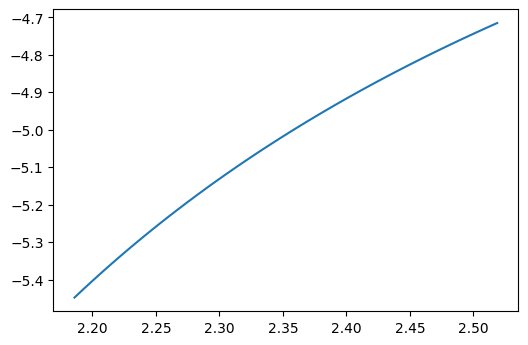

In [748]:
fig, ax = plt.subplots(dpi=100)
ax.plot(om_2, om_2*d3_psi(om_2)/d2_psi(om_2))

In [320]:
print(d_psi(om_0), psi(om_0))

-2951.713627135137 -5150.000000000001


In [268]:
print(N, tip1, tip2, mirror, 1000)
print(Triangle.triangle(N, tip1, tip2, mirror, 1000))


0.4 (400, 300) (2200, 300) 3200 1000
"(if((1.29*x1 + 1387 - x2 > 0) && (-0.43*x1 + 1759 - x2 > 0),
	 if(-3.87*x1 + 1849 - x2 > 0,
	 0.5 * tanh(0.005*(1.29*x1 - 216 - x2)) + 0.5,
	 0.5 * tanh(0.005*(-0.43*x1 + 472 - x2)) + 0.5),
	 0)

 + if((-0.43*x1 + 961 - x2 < 0) && (1.29*x1 - 2998 - x2 < 0),
	 if(-3.87*x1 + 8821 - x2 > 0,
	 0.5 * tanh(0.005*(-(-0.43*x1 + 1247 - x2))) + 0.5,
	 0.5 * tanh(0.005*(-(1.29*x1 - 2540 - x2))) + 0.5),
	 0)

 + if((-1.29*x1 + 5264 - x2 < 0) && (0.43*x1 - 1793 - x2 < 0),
	 if(3.87*x1 - 15967 - x2 < 0,
	 0.5 * tanh(0.005*(-(-1.29*x1 + 5722 - x2))) + 0.5,
	 0.5 * tanh(0.005*(-(0.43*x1 - 1507 - x2))) + 0.5),
	 0)

 + if((0.43*x1 - 1995.9 - x2 > 0) && (-1.29*x1 + 8504.2 - x2 > 0),
	 if(3.87*x1 - 22938 - x2 < 0,
	 0.5 * tanh(0.005*(0.43*x1 - 2282 - x2)) + 0.5,
	 0.5 * tanh(0.005*(-1.29*x1 + 8046 - x2)) + 0.5),
	 0))

*step(x2 + 700)*step(-x2 + 1300)",


In [269]:
data = osh5io.read_h5('e2-000000.h5', './2d plasma short/MS/FLD/e2/')
print(np.argwhere(np.abs(data.axes[0].ax) < 0.5)[0][0])
arr = data.view(np.ndarray)[np.argwhere(np.abs(data.axes[0].ax) < 0.5)[0][0]]

""" data2 = osh5io.read_h5('e2-000083.h5', './2d 4 triangle//MS/FLD/e2/')
print(np.argwhere(np.abs(data2.axes[0].ax) < 0.5)[0][0])
arr2 = data2.view(np.ndarray)[np.argwhere(np.abs(data2.axes[0].ax) < 0.5)[0][0]] """


512


" data2 = osh5io.read_h5('e2-000083.h5', './2d 4 triangle//MS/FLD/e2/')\nprint(np.argwhere(np.abs(data2.axes[0].ax) < 0.5)[0][0])\narr2 = data2.view(np.ndarray)[np.argwhere(np.abs(data2.axes[0].ax) < 0.5)[0][0]] "

Δt = 0.4147529264746481
tau_1 = 30.0


[Text(0.5, 0, 't [fs]')]

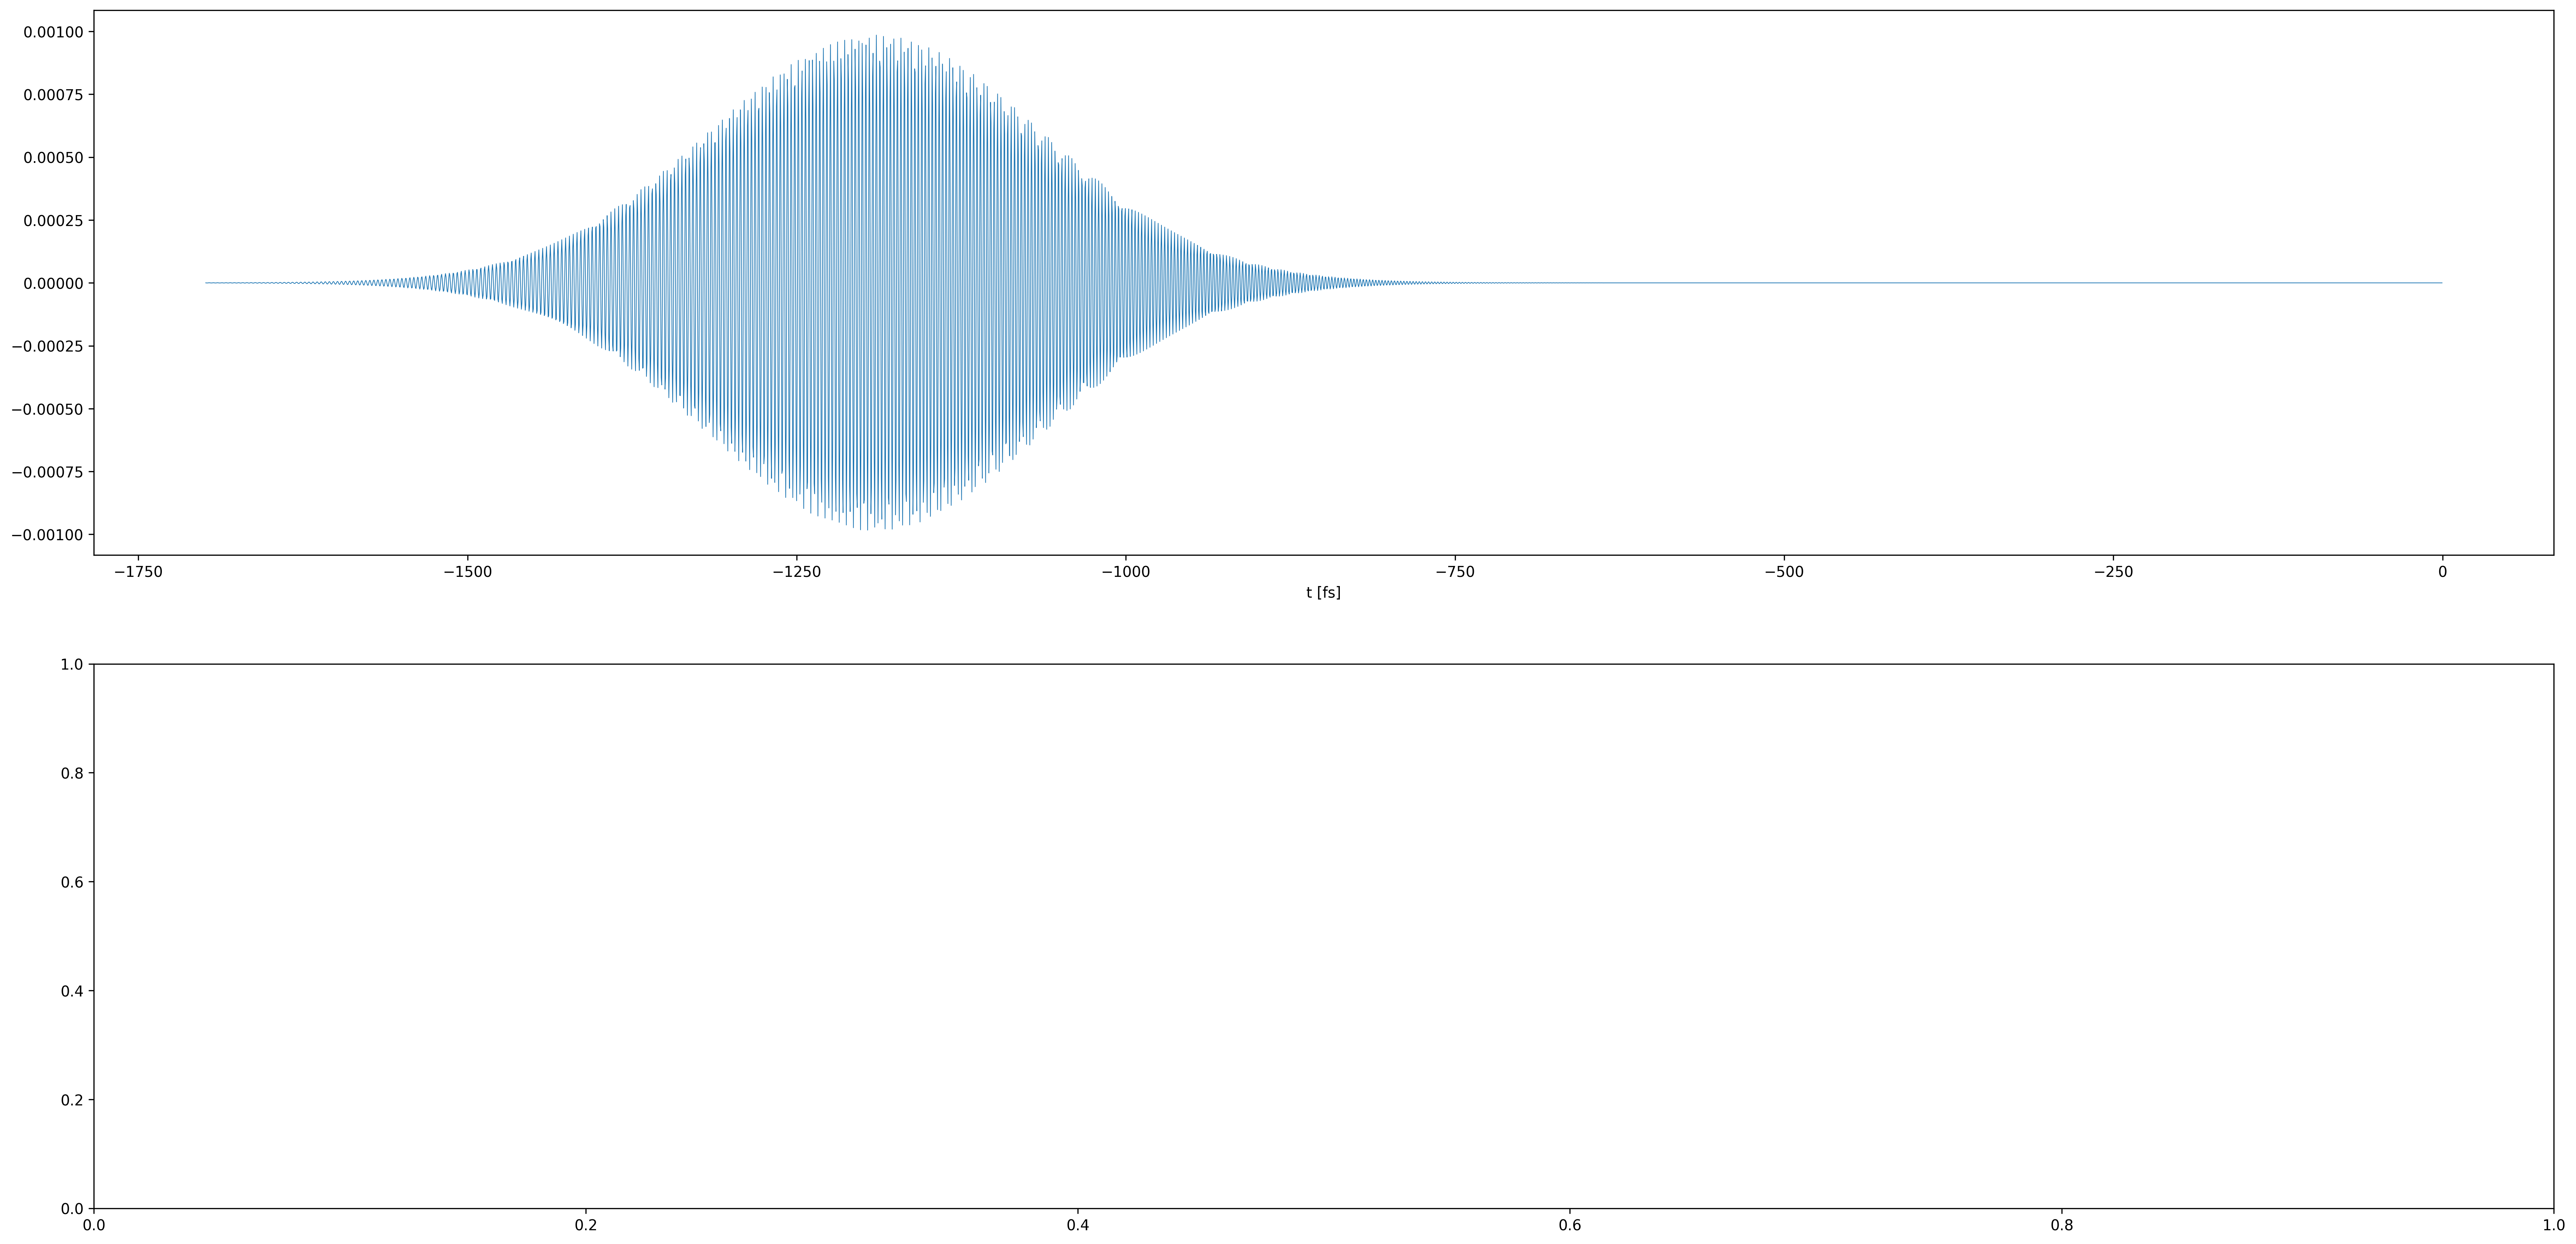

In [270]:
N = 2**14
c = 299792458*1e6*1e-15 # um / fs, speed of light
lamda = .8 # um
om_0 = 2*np.pi*c/lamda # 1/fs, ~2.36

E_0 = 2
tau_0 = 30 # fs
c_0 = 0 # chirp

#t = np.linspace(-tau_0*16,tau_0*16, N)
t = data.axes[1].ax / om_0
#E_in = np.exp(-0.5*((t/tau_0)**2)) * np.real(E_0 * np.exp(-0.5*((t/tau_0)**2)*(1j*c_0)) * np.exp(-1j*om_0*t))
E_in = arr
E_in = E_in[::-1]

delta_t = t[2]-t[1]
delta_omega = 2*np.pi/(N*delta_t)

print('Δt =', delta_t)

tau_1 = tau_0 / np.sqrt(1 + c_0**2)
print('tau_1 =', tau_1)
""" E_1 = 2
c_1 = 0
E_out = np.real(E_1 * np.exp(-0.5*((t/tau_1)**2)*(1+1j*c_1)) * np.exp(-1j*(om_0)*t)) """

""" t2 = data2.axes[1].ax
E_out = arr2
E_out = E_out[::-1] """

""" t2 = data2.axes[1].ax
E_out = arr2
E_out = E_out[::-1] """

fig, ax = plt.subplots(2, 1, dpi=300, figsize=(30,15))
ax[0].plot(t, E_in, linewidth=0.5)
ax[0].set(xlabel='t [fs]')
#ax[0].axvline(-3*tau_0, c='r')
#ax[0].axvline(3*tau_0, c='r')
#ax[1].plot(t2, E_out, linewidth=0.5)

In [280]:
def func(E_in, om_0, delta_t, a, b, c, d):
    phi = lambda w, a, b, c : a*(w) + b*(w**2) + c*(w**3) + d*(w**4)
    F_in = fft(E_in) * delta_t
    w = fftfreq(E_in.size, d=delta_t) * 2*np.pi
    pos_w = w[w >= 0] # positive half
    neg_w = w[w < 0]

    zeropoint = np.exp(1j*phi(pos_w[0]-om_0, a, b, c))
    pos_fltr = np.exp(1j*phi(pos_w[1:]-om_0, a, b, c))
    neg_fltr = np.conj(pos_fltr)
    lastpoint = np.exp(1j*phi(neg_w[0]-om_0, a, b, c))

    fltr = np.concatenate(([zeropoint], pos_fltr, [lastpoint], neg_fltr[::-1]))

    F_out = F_in * fltr

    E_out = ifft((F_out) / delta_t)


    threshold = 1e-4
    w_peaks = w[np.argwhere(np.abs(F_out)**2 > threshold)]

    F_peaks = F_out[np.argwhere(np.abs(F_out)**2 > threshold)]
    F_peaks = F_peaks[w_peaks >= 0]
    w_peaks = w_peaks[w_peaks >= 0]

    return E_out, w_peaks

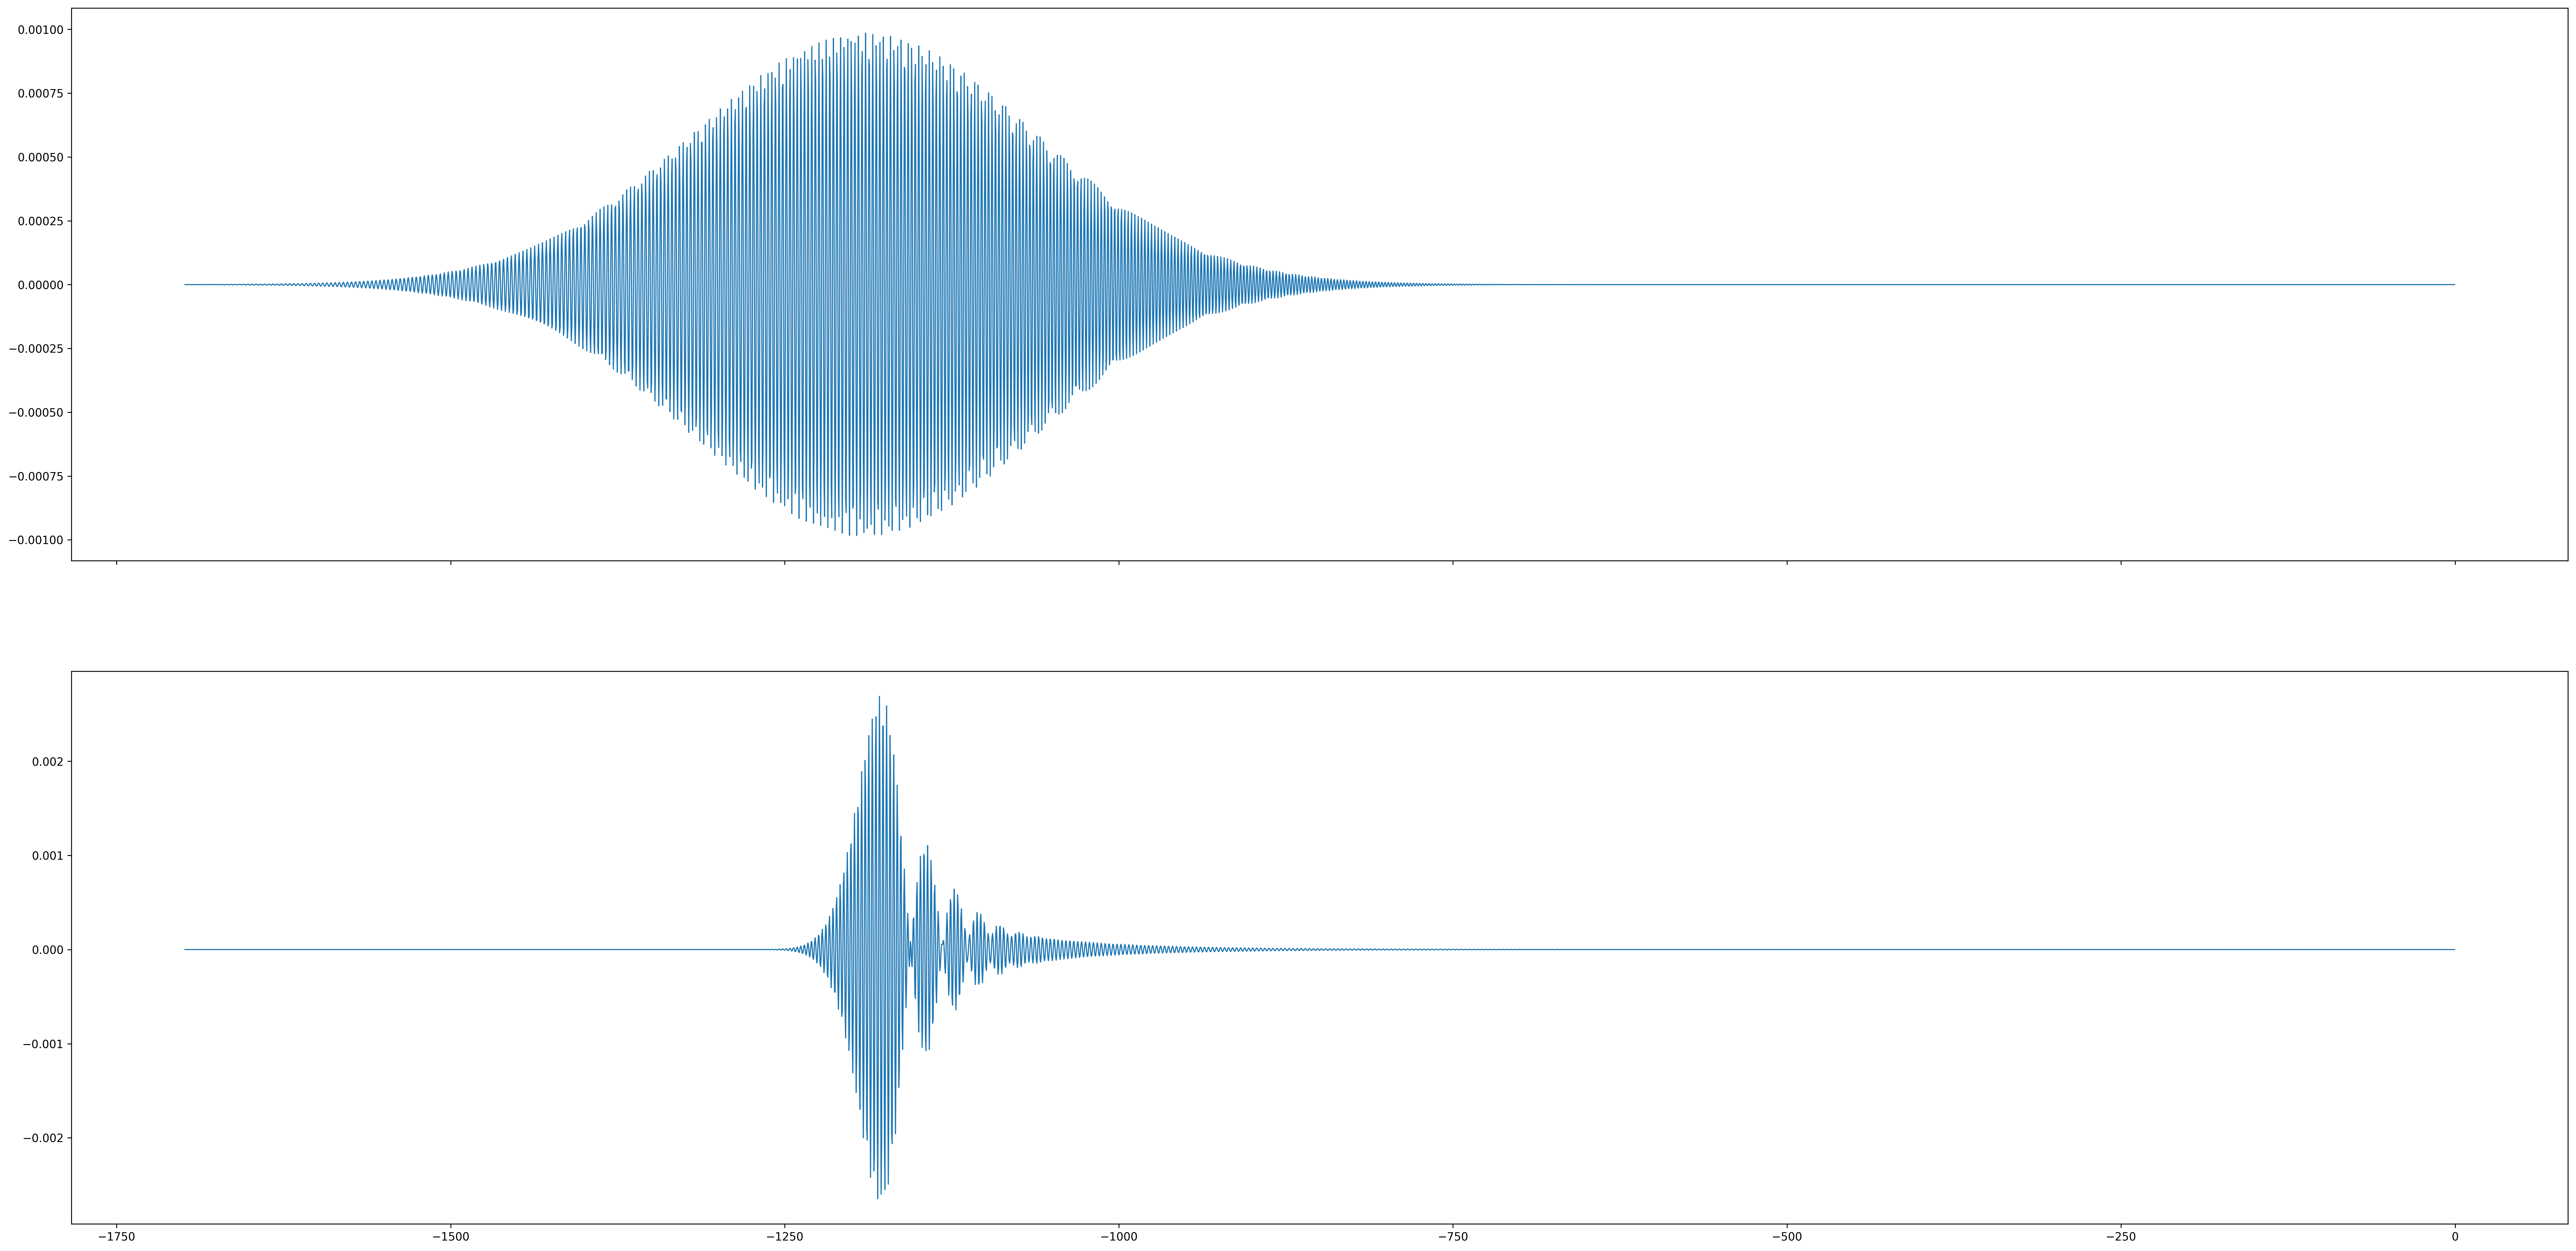

In [281]:
E_out_2, w_2 = func(E_in, om_0, delta_t, 0, 0, 0, 25.**4)
E_out_3, _ = func(E_in, om_0, delta_t, 0, coeff[-3], coeff[-4], coeff[-5])
fig, ax = plt.subplots(2, 1, dpi=300, figsize=(40,20), sharex=True)
#ax[0].plot(t, E_out, linewidth=0.5)
#ax[1].plot(t, np.real(E_out_2), linewidth=0.5)
ax[0].plot(t, E_in, linewidth=1)
ax[1].plot(t, np.real(E_out_3), linewidth=1)
#ax[0].plot(t, E_out, linewidth=1)

#ax[1].set(xlim=[400,600]);

WXYZ


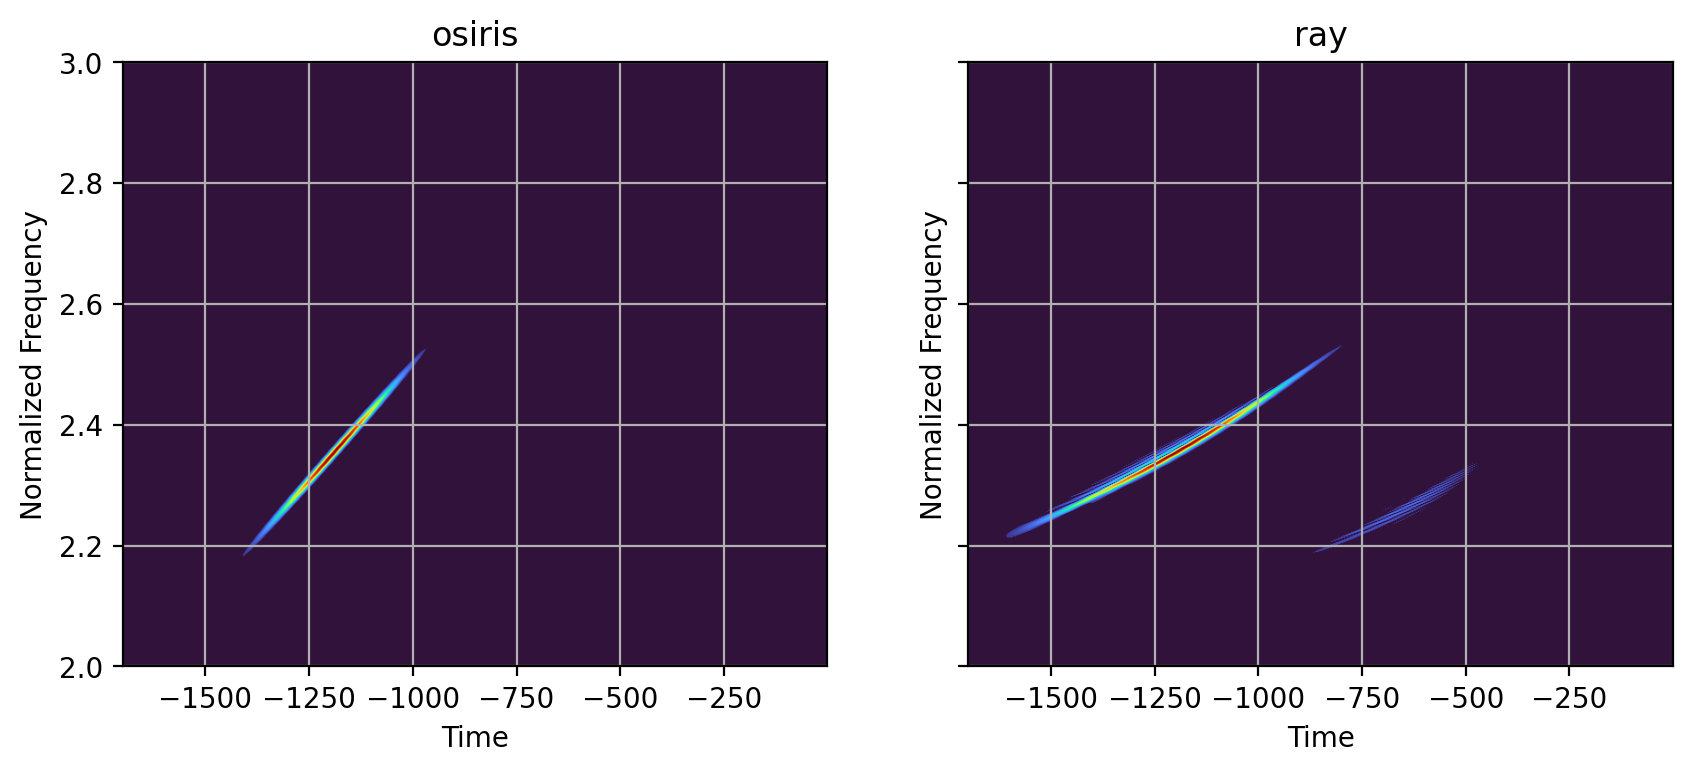

In [275]:
fig, ax = plt.subplots(1,2, dpi=200, figsize=(10,4), sharey=True)

wig1 = WVD(E_in, timestamps=t)
wig1.run(True)
print('W', end='')
wig1.plot(ax=ax[0], show=False, cmap='turbo')
print('X', end='')
ax[0].set(title='osiris')

wig2 = WVD(E_out_3, timestamps=t)
wig2.run(True)
print('Y', end='')
wig2.plot(ax=ax[1], show=False, cmap='turbo')
print('Z')
ax[1].set(ylim=[2,3], title='ray');


In [216]:
theta = np.arcsin(np.sin(brewster) / n(1,N))
slope1 = np.tan(np.pi/2. + theta - np.arcsin(n(1, N)*np.sin(theta)))

slope2 = (tips[1][1] - tips[0][1])/(tips[1][0] - tips[0][0])
print(180 - angleBetweenTwoSlopes(slope1, slope2) * 180/np.pi) 

95.01518997790431
